### Stealth in-place edits for correcting hallucinations

In [2]:
import sys

%cd ../../
%pwd

from tqdm import tqdm

# load utility functions
from util import utils
from util import evaluation
from util import extraction
from util import measures

from stealth_edit import compute_wb
from stealth_edit import edit_utils

from evaluation import eval_utils

#### Paths and Parameters

In [3]:
models = ['gpt-j-6b', 'llama-3-8b', 'mamba-1.4b']
datasets = ['mcf', 'zsre']

save_path = './results/in-place/'
results_path = './results/in-place/{}/{}/'

fs_path = './results/eval_fs/in-place/fs_in-place_{}_{}.pickle'

cache_path = './cache'
other_pickle = os.path.join(cache_path, 'wiki_test/wikipedia_features_{}_layer{}_w1.pickle')
features_cache_path = os.path.join(cache_path, 'prompts_extract_{}_{}.pickle')

theta = 0.005

Find all pickle files across layers

In [4]:
# find unique pickle files
pickle_paths = np.array([
    f for f in utils.path_all_files(save_path) \
        if f.endswith('.pickle') and ('perplexity' not in f)
])
_, unique_indices = np.unique(
    np.array([os.path.basename(f) for f in pickle_paths]), return_index=True)

pickle_paths = pickle_paths[unique_indices]
pickle_files = [os.path.basename(f) for f in pickle_paths]

# find edited case_ids
edited_case_ids = [int(f.split('.')[0]) for f in pickle_files]

In [4]:
# load PPL metrics
perplexity_metrics = {}

for dataset_name in datasets:

    across_model_metrics = {}
    for model_name in models:
        across_model_metrics[model_name] = evaluation.eval_model_ppl(
            model_name,
            results_path = results_path.format(dataset_name, model_name),
            eval_op = True,
            eval_oap = False,
            eval_ap = False,
            eval_aug = False,
            eval_rnd = False,
            num_examples = 1000
        )
    for model_name in models:
        across_model_metrics[model_name]['layer_indices'] = np.array([int(l.split('layer')[-1]) for l in across_model_metrics[model_name]['layer'][:,0]])

    summarise_metrics = {}
    for model_name in models:
        summarise_metrics[model_name] = evaluation.eval_model_ppl_metrics(
            across_model_metrics[model_name],
            eval_op = True,
            eval_oap = False,
            eval_ap = False,
            eval_aug = False,
            eval_rnd = False,
        )
    perplexity_metrics[dataset_name] = copy.deepcopy(summarise_metrics)

# load feature space metrics
mcf_fs_contents = {m: utils.loadpickle(fs_path.format('mcf', m)) for m in models}
zsre_fs_contents = {m: utils.loadpickle(fs_path.format('zsre', m)) for m in models}

100%|██████████| 7/7 [00:19<00:00,  2.77s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 8/8 [00:29<00:00,  3.68s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 7/7 [00:30<00:00,  4.34s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 8/8 [00:31<00:00,  3.99s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 12/12 [00:50<00:00,  4.19s/it]


#### Caclulate Intrinsic Dimensions

Calculate Theorem 2 intrinsic dimensions with `wikipedia` dataset

In [6]:
intrinsic_dims = {}

for model in models:

    print('\nCalculating for', model)
    intrinsic_dims_on_sphere, num_sampled = eval_utils.calculate_t2_intrinsic_dims(
        model,
        other_pickle,
        deltas = [2*(1-theta)**2-2],
        layers = evaluation.model_layer_indices[model],
        cache_norms_path = cache_path
    )
    intrinsic_dims[model] = intrinsic_dims_on_sphere

probs_wiki = {}
for key in intrinsic_dims:
    probs_wiki[key] = np.sqrt(2**(-intrinsic_dims[key][:,0]-1))


Calculating for gpt-j-6b


100%|██████████| 7/7 [00:04<00:00,  1.63it/s]



Calculating for llama-3-8b


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]



Calculating for mamba-1.4b


100%|██████████| 12/12 [00:02<00:00,  4.73it/s]


Calculate Theorem 2 intrinsic dimensions with the `mcf` and `zsre` datasets

In [7]:
probs_datasets = {}

for dataset in datasets:
    
    dataset_results = {}
    for model_name in models:

        layer_indices = evaluation.model_layer_indices[model_name]
        contents = utils.loadpickle(features_cache_path.format(dataset, model_name))

        # exlude edited case_ids
        mask = utils.generate_mask(contents['case_ids'], edited_case_ids)

        intrinsic_dims = []
        for i in tqdm(layer_indices):
            
            # project to sphere
            features = compute_wb.back_to_sphere(
                contents[i][~mask], 
                model_name, 
                norm_learnables = extraction.load_norm_learnables(
                    model_name, layer=i, cache_path=cache_path)
            )

            # calculate intrinsic dimension
            ids = measures.calc_sep_intrinsic_dim(
                features,
                centre = False,
                deltas = [2*(1-theta)**2-2]
            )
            intrinsic_dims.append(ids)    

        dataset_results[model_name] = np.sqrt(2**(-np.squeeze(np.array(intrinsic_dims))-1))
        
    probs_datasets[dataset] = dataset_results

100%|██████████| 12/12 [00:00<00:00, 16.17it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


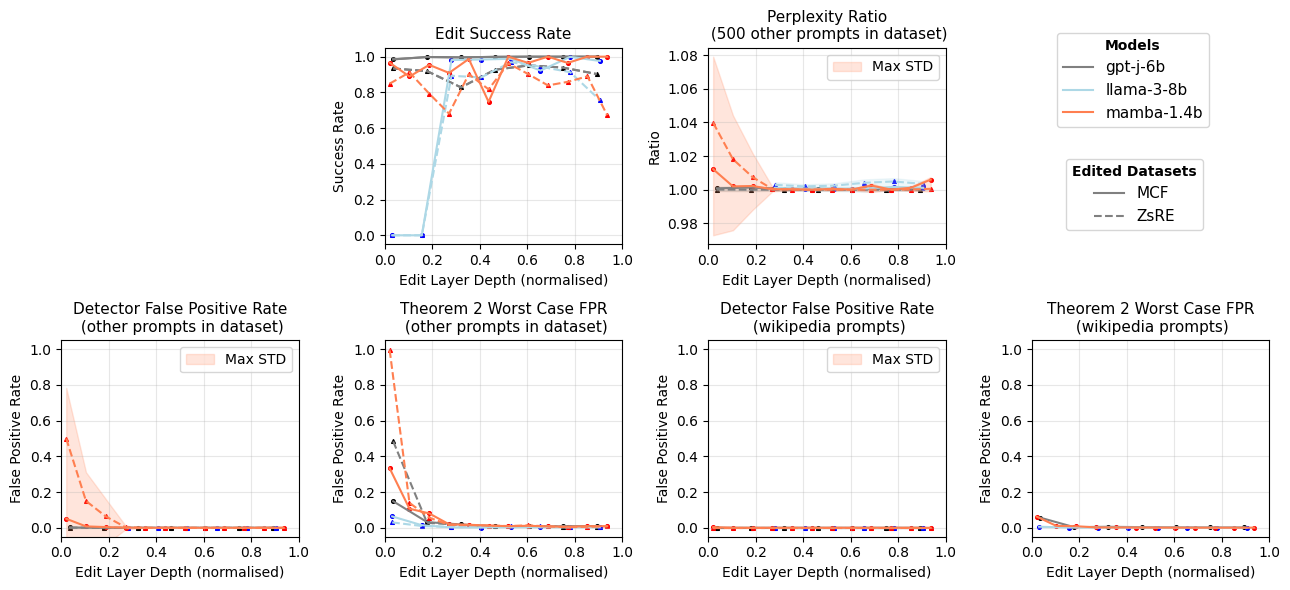

In [7]:
from util import evaluation
reload(evaluation)

fig, axs = plt.subplots(2, 4, figsize=(13, 6))

main_colors = ['black', 'b', 'red']
sub_colors = ['gray', 'lightblue', 'coral']

model_handles = []
dataset_handles = []


for i, model_name in enumerate(models):

    relative_depth = evaluation.model_layer_indices[model_name] \
        / evaluation.model_depth[model_name]

    axs[0,1].scatter(relative_depth, np.nan_to_num(perplexity_metrics['mcf'][model_name]['efficacy']), color=main_colors[i], s=7)
    axs[0,1].plot(relative_depth, np.nan_to_num(perplexity_metrics['mcf'][model_name]['efficacy']), color=sub_colors[i])

    axs[0,1].scatter(relative_depth, np.nan_to_num(perplexity_metrics['zsre'][model_name]['efficacy']), color=main_colors[i], s=7, marker='^')
    axs[0,1].plot(relative_depth, np.nan_to_num(perplexity_metrics['zsre'][model_name]['efficacy']), color=sub_colors[i], linestyle='--')

    axs[0,1].set_xlabel('Edit Layer Depth (normalised)')
    axs[0,1].set_ylabel('Success Rate')
    axs[0,1].set_title('Edit Success Rate', fontsize=11)
    axs[0,1].set_xlim([0,1])


    mcf_mean = perplexity_metrics['mcf'][model_name]['ppl_other_mean']
    mcf_std = perplexity_metrics['mcf'][model_name]['ppl_other_std']
    zsre_mean = perplexity_metrics['zsre'][model_name]['ppl_other_mean']
    zsre_std = perplexity_metrics['zsre'][model_name]['ppl_other_std']

    max_mean = np.maximum(zsre_mean, mcf_mean)
    min_mean = np.minimum(zsre_mean, mcf_mean)
    max_std = np.maximum(zsre_std, mcf_std)

    if i == 2:
        label_to_insert = 'Max STD'
    else:
        label_to_insert = None

    axs[0,2].scatter(relative_depth, mcf_mean, color=main_colors[i], s=7)
    axs[0,2].plot(relative_depth, mcf_mean, color=sub_colors[i])

    axs[0,2].scatter(relative_depth, zsre_mean, color=main_colors[i], s=7, marker='^')
    axs[0,2].plot(relative_depth, zsre_mean, color=sub_colors[i], linestyle='--')
    axs[0,2].fill_between(relative_depth, (min_mean-max_std), (max_mean+max_std), color=sub_colors[i], alpha=0.2, label=label_to_insert)

    axs[0,2].set_ylabel('Ratio')
    axs[0,2].set_xlabel('Edit Layer Depth (normalised)')
    axs[0,2].set_title('Perplexity Ratio\n (500 other prompts in dataset)', fontsize=11)
    axs[0,2].legend()
    axs[0,2].set_xlim([0,1])

    mcf_mean_other_fprs = mcf_fs_contents[model_name]['mean_other_fprs']
    zsre_mean_other_fprs = zsre_fs_contents[model_name]['mean_other_fprs']
    mcf_std_other_fprs = mcf_fs_contents[model_name]['std_other_fprs']
    zsre_std_other_fprs = zsre_fs_contents[model_name]['std_other_fprs']

    max_mean_other_fprs = np.maximum(mcf_mean_other_fprs, zsre_mean_other_fprs)
    min_mean_other_fprs = np.minimum(mcf_mean_other_fprs, zsre_mean_other_fprs)
    max_std_other_fprs = np.maximum(mcf_std_other_fprs, zsre_std_other_fprs)

    axs[1,0].scatter(relative_depth, mcf_mean_other_fprs, color=main_colors[i], s=7)
    axs[1,0].plot(relative_depth, mcf_mean_other_fprs, color=sub_colors[i])

    axs[1,0].scatter(relative_depth, zsre_mean_other_fprs, color=main_colors[i], s=7, marker='^')
    axs[1,0].plot(relative_depth, zsre_mean_other_fprs, color=sub_colors[i], linestyle='--')
    axs[1,0].fill_between(relative_depth, (min_mean_other_fprs-max_std_other_fprs), (max_mean_other_fprs+max_std_other_fprs), color=sub_colors[i], alpha=0.2, label=label_to_insert)
    
    axs[1,0].set_xlabel('Edit Layer Depth (normalised)')
    axs[1,0].set_ylabel('False Positive Rate')
    axs[1,0].set_title('Detector False Positive Rate\n (other prompts in dataset)', fontsize=11)
    axs[1,0].set_xlim([0,1])
    axs[1,0].legend()
    axs[1,0].set_ylim([-0.05,1.05])


    axs[1,1].scatter(relative_depth, probs_datasets['mcf'][model_name], color=main_colors[i], s=7)
    axs[1,1].plot(relative_depth, probs_datasets['mcf'][model_name], color=sub_colors[i])

    axs[1,1].scatter(relative_depth, probs_datasets['zsre'][model_name], color=main_colors[i], s=7, marker='^')
    axs[1,1].plot(relative_depth, probs_datasets['zsre'][model_name], color=sub_colors[i], linestyle='--')

    axs[1,1].set_xlabel('Edit Layer Depth (normalised)')
    axs[1,1].set_ylabel('False Positive Rate')
    axs[1,1].set_title('Theorem 2 Worst Case FPR\n (other prompts in dataset)', fontsize=11)
    axs[1,1].set_xlim([0,1])
    axs[1,1].set_ylim([-0.05,1.05])


    mcf_mean_wiki_fprs = mcf_fs_contents[model_name]['mean_wiki_fprs']
    zsre_mean_wiki_fprs = zsre_fs_contents[model_name]['mean_wiki_fprs']
    mcf_std_wiki_fprs = mcf_fs_contents[model_name]['std_wiki_fprs']
    zsre_std_wiki_fprs = zsre_fs_contents[model_name]['std_wiki_fprs']

    max_mean_wiki_fprs = np.maximum(mcf_mean_wiki_fprs, zsre_mean_wiki_fprs)
    min_mean_wiki_fprs = np.minimum(mcf_mean_wiki_fprs, zsre_mean_wiki_fprs)
    max_std_wiki_fprs = np.maximum(mcf_std_wiki_fprs, zsre_std_wiki_fprs)

    axs[1,2].scatter(relative_depth, mcf_mean_wiki_fprs, color=main_colors[i], s=7)
    axs[1,2].plot(relative_depth, mcf_mean_wiki_fprs, color=sub_colors[i])

    axs[1,2].scatter(relative_depth, zsre_mean_wiki_fprs, color=main_colors[i], s=7, marker='^')
    axs[1,2].plot(relative_depth, zsre_mean_wiki_fprs, color=sub_colors[i], linestyle='--')
    axs[1,2].fill_between(relative_depth, (min_mean_wiki_fprs-max_std_wiki_fprs), (max_mean_wiki_fprs+max_std_wiki_fprs), color=sub_colors[i], alpha=0.2, label=label_to_insert)

    axs[1,2].set_xlabel('Edit Layer Depth (normalised)')
    axs[1,2].set_ylabel('False Positive Rate')
    axs[1,2].set_title('Detector False Positive Rate\n (wikipedia prompts)', fontsize=11)
    axs[1,2].set_xlim([0,1])
    axs[1,2].legend()
    axs[1,2].set_ylim([-0.05,1.05])

    
    axs[1,3].scatter(relative_depth, probs_wiki[model_name], color=main_colors[i], s=7)
    mh = axs[1,3].plot(relative_depth, probs_wiki[model_name], color=sub_colors[i], label=model_name)
    model_handles.append(mh[0])

    axs[1,3].set_xlabel('Edit Layer Depth (normalised)')
    axs[1,3].set_ylabel('False Positive Rate')
    axs[1,3].set_title('Theorem 2 Worst Case FPR\n (wikipedia prompts)', fontsize=11)
    axs[1,3].set_xlim([0,1])
    axs[1,3].set_ylim([-0.05,1.05])

    if i == 0:
        dh0 = axs[0,1].plot(relative_depth, np.nan_to_num(perplexity_metrics['mcf'][model_name]['efficacy']), color=sub_colors[i], label='MCF')
        dh1 = axs[0,1].plot(relative_depth, np.nan_to_num(perplexity_metrics['zsre'][model_name]['efficacy']), color=sub_colors[i], linestyle='--', label='ZsRE')
        dataset_handles.append(dh0[0])
        dataset_handles.append(dh1[0])


model_legend = fig.legend(model_handles, ['gpt-j-6b', 'llama-3-8b', 'mamba-1.4b'], bbox_to_anchor=(0.94, 0.95), loc = 'upper right', title='Models', title_fontproperties={'weight':'bold'}, fontsize=11)
dataset_legend = fig.legend(dataset_handles, ['MCF', 'ZsRE'], bbox_to_anchor=(0.935, 0.74), loc = 'upper right', title='Edited Datasets', title_fontproperties={'weight':'bold'}, fontsize=11)


axs[0,0].axis('off')
axs[0,3].axis('off')

for i in range(2):
    for j in range(4):
        axs[i,j].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('in-place.png', dpi=300)

plt.show()